### Part 1 Explore the TX population and unemployment rate
#### Part 1.1 Prepare the geospatial data (15 points)

On Canvas, there is a csv file called "unemp.csv", which contains county-level information about unemployment rate and population. Use county level geo-spatial data provided in the lecture to merge two datasets. Then extract the part of data for Texas and make a map for Texas county. Only show the boundary for the counties. 

Note: Texas has 254 counties, more than any other U.S. state.

In [3]:
import geopandas as gpd
import geodatasets
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import folium
import matplotlib.patches as mpatches

# Load unemployment data
unemp = pd.read_csv('unemp.csv')

county = gpd.read_file("ne_10m_admin_2_counties/ne_10m_admin_2_counties.shp")

# Remove 'US' prefix and convert 'FIPS' column to int64
county['FIPS'] = county['FIPS'].str.replace('US', '')
county['FIPS'] = pd.to_numeric(county['FIPS'], errors='coerce')
full = pd.merge(county, unemp, left_on = "FIPS", right_on = "fips", how = "outer")

<Axes: >

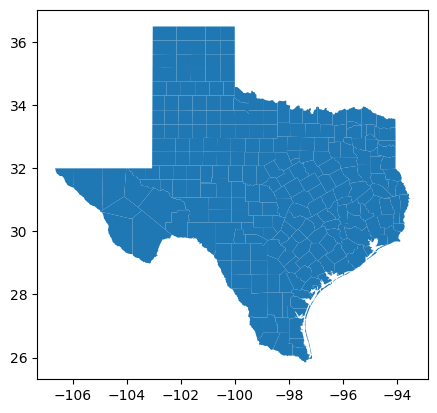

In [4]:
# The FIPS for MA is 25
TX = full[full['ISO_3166_2'] == "US-48"]
TX.plot()

#### Part 1.2 creating choropleth maps and customization (10 points)

Make a choropleth maps with unemployment rate. Choose another color map from
https://matplotlib.org/stable/users/explain/colors/colormaps.html. Give a title to the figure (use `plt.title`) as well as a title to the legend. 


Text(0.5, 1.0, 'Unemployment Rate by County in Texas')

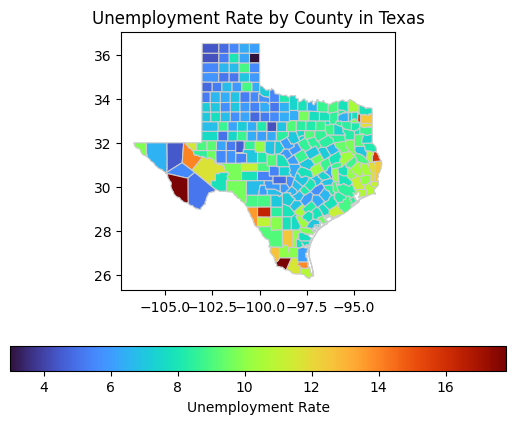

In [5]:
fig, ax = plt.subplots(1, 1)
TX.plot(column='unemp', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
           legend_kwds={'label': "Unemployment Rate", 'orientation': "horizontal"})
plt.title('Unemployment Rate by County in Texas')

#### Part 1.3 Handle the missing values (15 points)

Make a copy of your Texas data. Like what we have done in the lecture, randomly select 30 counties and set the unemployment rate as NaN. Plot the choropleth maps for the unemployment rate again. Define the color, boundary, and hatch pattern for the missing value areas. Also include a legend for the missing areas. Chooes a hatch pattern that is different from the lecture note from here: https://matplotlib.org/devdocs/gallery/shapes_and_collections/hatch_style_reference.html

Text(0.5, 1.0, 'Unemployment Rate by County in Texas (with Missing Data)')

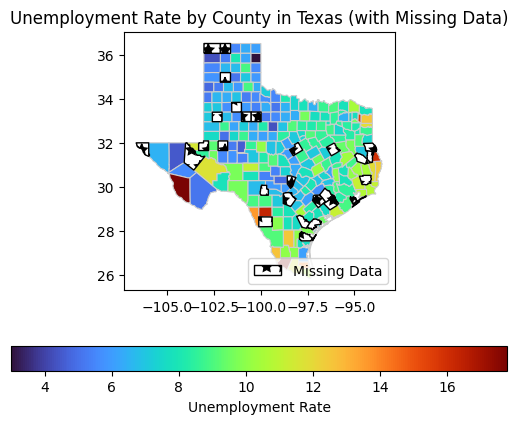

In [6]:
# Make a copy of the Texas data
texas_copy = TX.copy()

# Randomly select 30 counties and set the unemployment rate as NaN
texas_copy.loc[np.random.choice(texas_copy.index, 30), 'unemp'] = np.nan

# Plot the choropleth maps for the unemployment rate again
fig, ax = plt.subplots(1, 1)
texas_copy.plot(column='unemp', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
           legend_kwds={'label': "Unemployment Rate", 'orientation': "horizontal"})

# Define the color, boundary, and hatch pattern for the missing value areas
texas_copy[texas_copy['unemp'].isna()].plot(ax=ax, color='white', edgecolor='k', hatch='*')

# Include a legend for the missing areas
legend_elements = [Patch(facecolor='white', edgecolor='k', hatch='*', label='Missing Data')]
ax.legend(handles=legend_elements, loc='lower right')

plt.title('Unemployment Rate by County in Texas (with Missing Data)')

#### Part 1.4 Multiple-layer plots (25 points)

There is another attribute in the data which is called `pop`. This attributes represent the population in each county. This is a highly skewed attributed thus we first create a new attribute called `logpop`, which is the log of the population. Then make a map with two layers, one layer is the `logpop` and the second layer is `unemp`. Overlap both layers on the same map. Create one static figure and one interactive figure. In the interactive figure, the user should be able to select one or both layer to show and when they click the county, the information of population and unemployment rate are displayed. 

Note: You may need to create another copy of the data to show both layers. Also, you may need to add some transparency to the top layer so that the bottom layer can be seen. 

In the end, discuss how the overlapping colors and transparency factor affect people's understanding. 

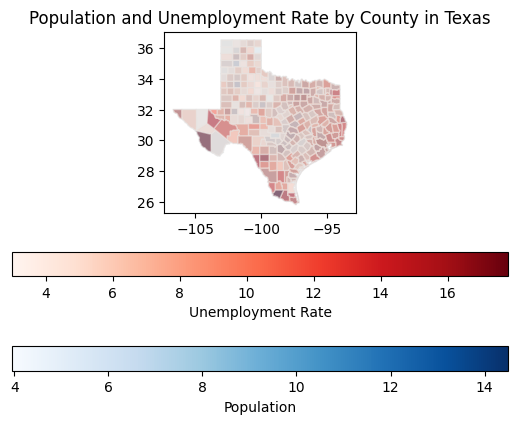

In [7]:
# Create a new attribute `logpop` which is the log of the population
texas_copy_full = TX.copy()
texas_copy_full['logpop'] = np.log(texas_copy_full['pop'])

# Make a static map with two layers: `logpop` and `unemp`
fig, ax = plt.subplots(1, 1)

# Plot the 'logpop' column
texas_copy_full.plot(column='logpop', cmap='Blues', ax=ax, edgecolor='0.9', alpha=0.5, legend=True, legend_kwds={'label': "Population", 'orientation': "horizontal"})

# Plot the 'unemp' column
texas_copy_full.plot(column='unemp', cmap='Reds', ax=ax, edgecolor='0.9', alpha=0.5, legend=True, legend_kwds={'label': "Unemployment Rate", 'orientation': "horizontal"})


plt.title('Population and Unemployment Rate by County in Texas')
plt.show()

In [8]:
# Convert the DataFrame to a GeoDataFrame if it's not already
geodf = gpd.GeoDataFrame(texas_copy, geometry='geometry')

# Add a new column 'logpop' by taking the logarithm of the 'pop' column
texas_copy['logpop'] = np.log(texas_copy['pop'])

# Convert the DataFrame to a GeoDataFrame if it's not already
geodf = gpd.GeoDataFrame(texas_copy, geometry='geometry')
# Create a base map
m = folium.Map(location=[31.9686, -99.9018], zoom_start=6)  # coordinates of Texas

# Create a choropleth map for logpop and add it to the base map
logpop = folium.Choropleth(
    geo_data=geodf,
    name='logpop',
    data=geodf,
    columns=['FIPS', 'logpop'],
    key_on='feature.properties.FIPS',
    fill_color='BuGn',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='logpop',
    smooth_factor=0
).add_to(m)

# Add a tooltip to the logpop layer
logpop.geojson.add_child(
    folium.features.GeoJsonTooltip(['FIPS', 'logpop'], labels=True)
)

# Create a choropleth map for unemp and add it to the base map
unemp = folium.Choropleth(
    geo_data=geodf,
    name='unemp',
    data=geodf,
    columns=['FIPS', 'unemp'],
    key_on='feature.properties.FIPS',
    fill_color='YlOrRd',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='unemp',
    smooth_factor=0
).add_to(m)

# Add a tooltip to the unemp layer
unemp.geojson.add_child(
    folium.features.GeoJsonTooltip(['FIPS', 'unemp'], labels=True)
)

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m
m.save('texas_choropleth_map.html')

When creating visualizations, the use of overlapping colors and transparency can greatly affect how the information is perceived and understood by the viewer. Here are some points to consider:

1. **Overlapping Colors**: When two colors overlap, they blend to create a new color. This can be useful for showing areas of intersection between two datasets. However, it can also be confusing if the color blending isn't intuitive or if the resulting color implies a different data value. For example, if you're using red to indicate high unemployment and blue to indicate high population, an area with both might appear purple. Without a clear legend, it might be unclear what purple represents.

2. **Transparency**: The use of transparency (or alpha) can help distinguish overlapping areas and mitigate some of the confusion caused by color blending. A lower alpha value means more transparency, which allows for better visibility of layers beneath. However, too much transparency can make the data appear diluted or less significant, and it can be harder to distinguish the colors if they're too faint.

3. **Color Perception**: Not everyone perceives color in the same way. For instance, colorblind individuals may have difficulty distinguishing certain color combinations. Tools like colorblind filters can help ensure your visualizations are accessible to everyone.

4. **Cognitive Load**: Overlapping colors and transparency increase the complexity of the visualization, which can increase the cognitive load for the viewer. If the visualization is too complex, it may be difficult for the viewer to extract the intended information.

In conclusion, while overlapping colors and transparency can be useful for showing complex relationships in data, they should be used thoughtfully and with consideration for the viewer's ability to accurately interpret the visualization. It's always a good idea to include clear legends and explanations to aid in interpretation.

### Part 2 In-class activity 3 (15 points)

Explore the information on 
https://www.naturalearthdata.com/downloads/ and download two datasets. For example, a world map as well as world airport locations. Create one interactive map with tooltip and popout functions. 

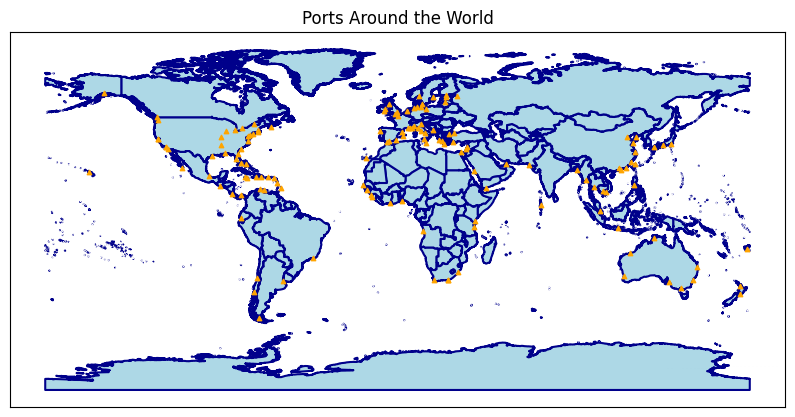

In [9]:
countries = gpd.read_file("ne_10m_admin_0_countries_usa/ne_10m_admin_0_countries_usa.shp")
countries.head()

ports = gpd.read_file("ne_50m_ports/ne_50m_ports.shp")
ports.head()

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot countries with custom color and linewidth
countries.plot(ax=ax, color='lightblue', edgecolor='darkblue', linewidth=1.5)

# Plot ports with custom color and marker
ports.plot(ax=ax, color='orange', markersize=10, marker='^')

# Remove x and y axis numbers
ax.set_xticks([])
ax.set_yticks([])

# Add title
ax.set_title('Ports Around the World')

# Show the plot
plt.show()

### Part 3 D3 Practice again (20 points)

Replicate the bar plot (screenshot is attached on Canvas) in the sample project with D3. Also add an interaction option to the figure, such that users can click a couple of bars and highlight them with another color.  